# Homework 5: Stochastic gradient algorithms#


Link to homework - http://www.harchaoui.eu/zaid/teaching/nyu/fall2015/cml_hw5.pdf

### 2) Linear Support Vector Machines ###
#### 2.1 Linear SVMs with gradient descent####
##### 2.1.1 #####

In [1]:
%matplotlib inline
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

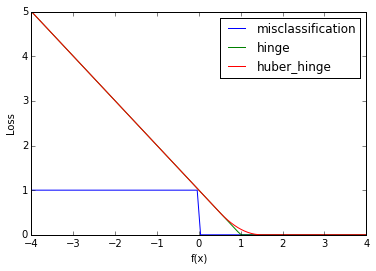

In [2]:
'''
Plotting the misclassification error loss, the (regular) hinge 
loss and the huberized hinge loss.

'''
f_x = np.linspace(-4, 4, 100)


def misclassification(f_x):
    return [1 if i <= 0 else 0 for i in f_x ]

def hinge(f_x):
    #consider y (predicted value) = 1
    return [np.max([0, 1-i]) for i in f_x ]

def huber_hinge(y, t ):
    
    z = y*t
    h = 0.5
    
    loss = [0]*z.shape[0]
    for i, x in enumerate(z):
        if x > 1+h:
            loss[i] = 0
        elif abs(1-x) <= h:
            loss[i] = ((1+h-x)**2)/(4*h)
        else:
            loss[i] = 1-x
    return loss

plt.plot(f_x, misclassification(f_x), label = 'misclassification')
plt.plot(f_x, hinge(f_x), label = 'hinge')
plt.plot(f_x, huber_hinge(1, f_x), label = 'huber_hinge')


plt.legend(loc="upper right")
plt.xlabel("f(x)")
plt.ylabel("Loss")


##### 2.1.2 Analytic expressions #####

In [3]:
def compute_obj(w, X, y):
        
    f_x = np.dot(X, w)
    n = X.shape[0]
        
    F = np.dot(w,w) + float(C/n) * np.dot(huber_hinge(y, f_x), np.ones(X.shape[0]))

    return F

#compute derivative of huber hinge loss function
def huber_diff(Y,T):
    
    h = 0.5
    
    loss = [0]*Y.shape[0]
    
    for i, (y, t) in enumerate(zip(Y,T)):
        if y*t > 1+h:
            loss[i] = 0
        elif abs(1-y*t) <= h:
            loss[i] = -((1+h-y*t)*y)/(2*h)
        else:
            loss[i] = -y
    return loss

def compute_grad(w, X, y):

    f_x = np.dot(X,w)
    n = X.shape[0]
        
    G = 2* w + float(C/n) * np.dot(huber_diff(y, f_x),  X)
    return G

##### 2.1.3 Numerical checks #####


In [4]:
from sklearn import preprocessing

def grad_checker(compute_grad, compute_obj, X, y):
    e = 1e-4
    #print(X)
    check = []
    
    w = []
    for i in range(X.shape[1]):
        w.append(np.random.random())
        
    w = np.array(w)
    
    for index in range(X.shape[1]):
        
        basis = np.zeros(X.shape[1])
        basis[index] = 1.0
        
        w_plus = w + e * basis
        w_minus = w - e * basis
        num = (compute_obj(w_plus, X, y) - compute_obj(w_minus, X, y))/(2*e)
        check.append(num)    
        
    
    gradient = compute_grad(w, X, y)
    gradient = np.array(gradient)
    check = np.array(check)
  
    return np.linalg.norm(gradient - check)

##### 2.1.4 Gradient Descent #####

In [5]:
def my_gradient_descent(n, max_iter, X, y, compute_grad, compute_obj, w):
    
   
    obj = [None]*max_iter
    
    error = np.zeros(max_iter)
    
    for i in range(max_iter):
        
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        
        error[i] = num_error
         
        obj[i] = compute_obj(w, X, y)
        w = w - n* compute_grad(w,X, y)
        
        
    return w, obj, error



In [7]:
from sklearn.cross_validation import train_test_split

def dataset(n, dim):
   
    np.random.seed(0)
    C = np.array([[0., -0.25], [0.80, .25]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 2])]
    y = np.hstack((-1*np.ones(n), np.ones(n)))
    return X, y

x, y = dataset(500, 2)
x = np.column_stack( (x, np.ones(x.shape[0])))
x = preprocessing.scale(x)
rng = np.random.RandomState(0)
permutation = rng.permutation(len(x))
x_mod, y_mod = x[permutation], y[permutation]


X_train, X_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.5)



In [9]:
C = 1
print(grad_checker(compute_grad, compute_obj, X_train, y_train))


2.14001104701e-12


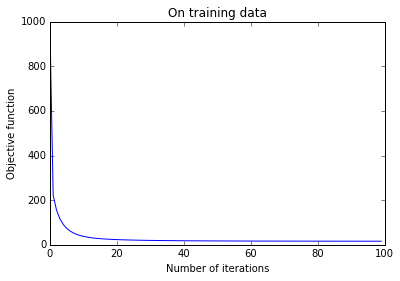

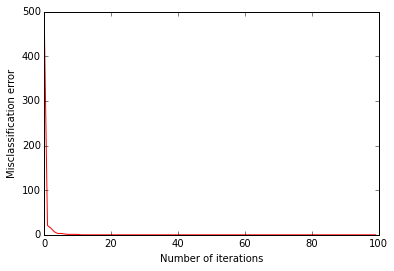

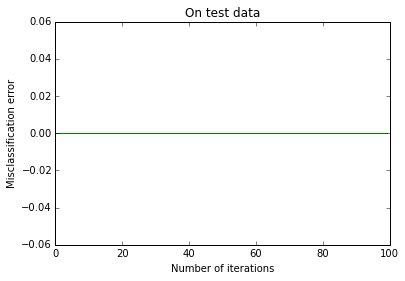

In [10]:
C= 1000
w = np.zeros(X_train.shape[1])
w, obj, error = my_gradient_descent(0.001, 100, X_train, y_train ,compute_grad, compute_obj, w)
index = [i for i in range (100)]

plt.title("On training data")
plt.plot(index, obj)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.figure()
plt.plot(index, error, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")



w1, obj1, error1 = my_gradient_descent(0.001, 100, X_test, y_test ,compute_grad, compute_obj, w)
plt.figure()
plt.title("On test data")
plt.plot(index, error1, "-g")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")


To optimize F and reduce the misclassification error, I modified the parameters C and n (step size). C= 1000 and n = 0.001 with number of iterations = 100 seems to give a misclassification error of 0 after about 25 iterations.



In [12]:
'''
Linear SVM with huberized hinge loss, trained using a gradient descent algorithm 
'''
def my_svm(n, max_iter, X, y, compute_grad, compute_obj):
    g = []
    w = np.zeros(X.shape[1])
    for x in X:
        
        w, o, e = my_gradient_descent(n, max_iter, X, y, compute_grad, compute_obj, w)
       
        f_x = np.dot(w, x)
        g.append(int(np.sign(f_x)))
     
        
    return w, g, obj

n = 0.001
w, g, obj = my_svm(n,100,X_train, y_train, compute_grad, compute_obj)

 



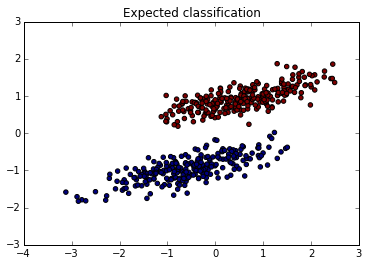

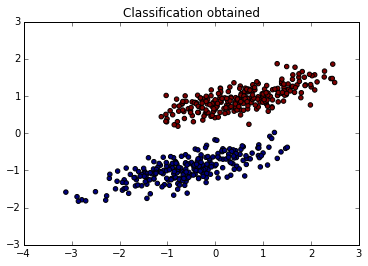

In [15]:
g = np.array(g)


plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Expected classification")

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=g)
plt.title("Classification obtained")





In [68]:
'''
gradient descent algorithm with backtracking line search

Reference: http://users.ece.utexas.edu/~cmcaram/EE381V_2012F/Lecture_4_Scribe_Notes.final.pdf
'''

def gradient_backtracking(max_iter, X, y,compute_grad, compute_obj):
    
    alpha = 0.1 # chosen between 0.01 and 0.3
    beta = 0.8 #between 0.1 and 0.8
    
    n = 1 #initial step size
    w = np.zeros(X.shape[1])
    
    obj = [None]*max_iter
    mis = np.zeros(max_iter)
    
    for k in range(max_iter):
        
        grad = compute_grad(w, X, y)
        obj[k] = compute_obj(w, X, y)
        
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        mis[i] = num_error
        
        while compute_obj((w - n*grad), X, y) > (compute_obj(w, X, y) - alpha*n* np.dot(grad, grad)):
            n = beta * n
        
        
        w = w- n*compute_grad(w, X, y)
        
    return w, obj, error

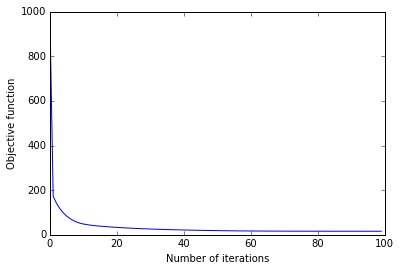

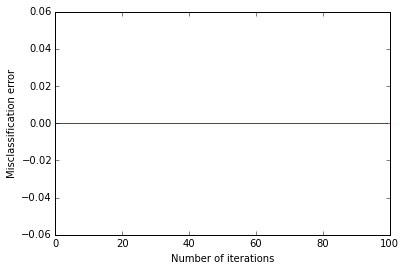

In [71]:
C = 1000
w, obj, error = gradient_backtracking( 100, X_train, y_train ,compute_grad, compute_obj)
index = [i for i in range (len(obj))]

plt.plot(index, obj)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.figure()


plt.plot(index, error, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")


In [201]:
import cProfile
cProfile.run('gradient_backtracking( 100, X_train, y_train ,compute_grad, compute_obj)')

         103769 function calls in 0.968 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006    0.968    0.968 <ipython-input-186-335616b243f2>:7(gradient_backtracking)
      342    0.418    0.001    0.438    0.001 <ipython-input-31-d9714a37192b>:16(huber_hinge)
      342    0.013    0.000    0.580    0.002 <ipython-input-32-361ba7a28397>:1(compute_obj)
      200    0.238    0.001    0.298    0.001 <ipython-input-32-361ba7a28397>:14(huber_diff)
      200    0.011    0.000    0.378    0.002 <ipython-input-32-361ba7a28397>:29(compute_grad)
        1    0.000    0.000    0.968    0.968 <string>:1(<module>)
      342    0.002    0.000    0.010    0.000 numeric.py:141(ones)
    99907    0.029    0.000    0.029    0.000 {abs}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
     1547    0.192    0.000    0.192    0.000 {numpy.core._dotblas.dot}
      342    0.00

After profiling the code, it is found that the bottlenecks are the functions huber_hinge and huber_diff. Previously, I was using the append function to add to the list that stored the loss function calculation. Adding an element by specifying the index (loss[i] = ...) improved the performance.

In [202]:
import cProfile
cProfile.run('my_gradient_descent(0.001, 100, X_train, y_train ,compute_grad, compute_obj)')

         79297 function calls in 0.446 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.446    0.446 <ipython-input-200-29e5d7c8ae41>:1(my_gradient_descent)
      100    0.155    0.002    0.166    0.002 <ipython-input-31-d9714a37192b>:16(huber_hinge)
      100    0.004    0.000    0.206    0.002 <ipython-input-32-361ba7a28397>:1(compute_obj)
      100    0.166    0.002    0.197    0.002 <ipython-input-32-361ba7a28397>:14(huber_diff)
      100    0.005    0.000    0.238    0.002 <ipython-input-32-361ba7a28397>:29(compute_grad)
        1    0.000    0.000    0.446    0.446 <string>:1(<module>)
      100    0.001    0.000    0.002    0.000 numeric.py:141(ones)
    77992    0.020    0.000    0.020    0.000 {abs}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
      500    0.070    0.000    0.070    0.000 {numpy.core._dotblas.dot}
      100    0.001  

The gradient_backtracking function is slower than my_gradient_descent because there is an additional step to calculate the step size. (The code for calculation of misclassification error was commented out in my_gradient_descent).
Based on the graph, the number of iterations required to optimize F (the objective function) are less for the gradient descent algorithm with backtracking.

In [116]:
def one_step_gradient(w, n,alpha, beta, X, y):
    grad = compute_grad(w, X, y)
    obj = compute_obj(w, X, y)
        
    while compute_obj((w - n*grad), X, y) > (compute_obj(w, X, y) - alpha*n* np.dot(grad, grad)):
        n = beta * n
        w = w- n*compute_grad(w, X, y)
    
    return w, obj, n

In [167]:
'''
my_svm function modified to have different stopping criteria
'''
def my_svm_2( X, y, compute_grad, compute_obj, criteria):
    
    g = []
    w = np.zeros(X.shape[1])
    
    alpha = 0.1 # chosen between 0.01 and 0.3
    beta = 0.8 #between 0.1 and 0.8
    
    n = 1 #initial step size
    obj = []
    
    if criteria == 1:
        max_iter = input("Maximum number of iterations: ")
        obj = [None]*max_iter
        for x in X:
            for k in range(max_iter):
                w, obj[k], n = one_step_gradient(w,n,alpha, beta,X,y)
       
                
            f_x = np.dot(w, x)
            g.append(int(np.sign(f_x)))
     
        return w, g, obj

    #optimization based criterion     
    elif criteria == 2:
        eps = 1e-3
        obj.append(compute_obj(w, X, y))
        for x in X:
            
            while np.linalg.norm(obj[-1]) > eps:
                w, o, n = one_step_gradient(w,n,alpha, beta,X,y)
                obj.append(o)
                print(np.linalg.norm(obj[-1]))
                
            f_x = np.dot(w, x)
            g.append(int(np.sign(f_x)))
     
        return w, g, obj
   
    #generalization-performance based criterion
    return w, g, obj
        

In [105]:

C_list = [10**i for i in range(-8, 6)]
index = [i for i in range (100)]
obj_list = np.zeros(len(C_list))
error = []
for p in range(len(C_list)):
    C = C_list[p]
    w, obj, e = gradient_backtracking(100, X_train, y_train ,compute_grad, compute_obj)
    obj_list[p] = (np.linalg.norm(obj[-1]-obj[0])/sum(obj))
    error.append(e)
    
print(obj_list)

obj_list = obj_list/sum(obj_list)
print(np.argmin(error))



[  3.03881293e-11   3.03881302e-10   3.03881382e-09   3.03882199e-08
   3.03890381e-07   3.03972219e-06   3.04793027e-05   3.13251687e-04
   3.70723702e-03   2.48498618e-02   1.05684243e-01   2.57302158e-01
   4.46410332e-01   5.36148729e-01]
0


In [146]:
C = 10000
w, g, obj = my_svm_2(X_train, y_train, compute_grad, compute_obj, 1)


Maximum number of iterations: 100


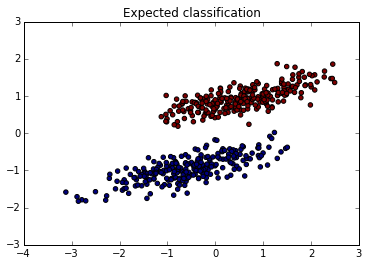

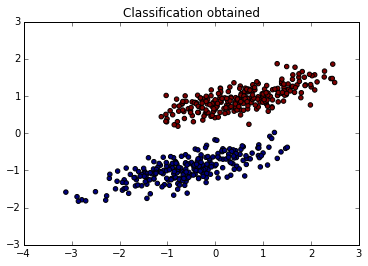

In [150]:
g = np.array(g)
X0, X1 = X_train[g == 1], X_train[g == -1]


plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Expected classification")

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=g)
plt.title("Classification obtained")


In [ ]:
C = 10000
w2, g2, obj2 = my_svm_2(X_train, y_train, compute_grad, compute_obj, 2)

g2 = np.array(g2)
X4, X5 = X_train[g2 == 1], X_train[g2 == -1]


plt.plot(X4[:, 0], X4[:,1], 'o', color='red')
plt.plot(X5[:, 0], X5[:, 1], 's', color='blue')

plt.figure()
X6, X7 = X_train[y_train == 1], X_train[y_train == -1]

plt.plot(X6[:, 0], X6[:,1], 'o', color='red')
plt.plot(X7[:, 0], X7[:, 1], 's', color='blue')

print(w)

10000.0
34175201.8216
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.06899561
8266.0689956

### Scikit-learn SVM##

1.0

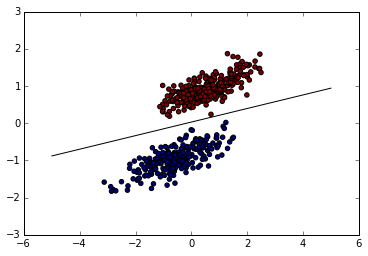

In [155]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - clf.intercept_[0] / w[1]

plt.plot(xx, yy, 'k-')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

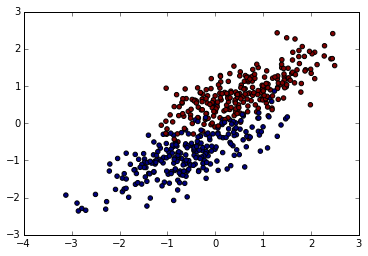

In [166]:
'''
Modify dataset to have some overlap
'''

from sklearn.cross_validation import train_test_split

def dataset2(n, dim):
   
    np.random.seed(0)
    C = np.array([[0., -0.25], [0.80, .25]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((-1*np.ones(n), np.ones(n)))
    return X, y

x, y = dataset2(500, 2)
x = np.column_stack( (x, np.ones(x.shape[0])))
x = preprocessing.scale(x)
rng = np.random.RandomState(0)
permutation = rng.permutation(len(x_norm))
x_mod, y_mod = x[permutation], y[permutation]


X_train, X_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.5)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Accuracy on training set:  0.942
Accuracy on test set:  0.92


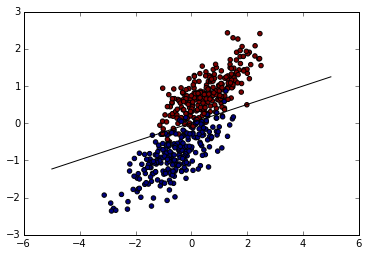

In [165]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - clf.intercept_[0] / w[1]

plt.plot(xx, yy, 'k-')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

print "Accuracy on training set: " , clf.score(X_train, y_train)
print "Accuracy on test set: " ,clf.score(X_test, y_test)